# MachineMax Technical Test - Data Generation

---
## Imports

In [1]:
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import random
import re
from enum import Enum
from tqdm import tqdm
from dataclasses import dataclass
from pykalman import KalmanFilter
from Codebase.utils import StateGenerator, RMSGenerator, IntervalGenerator, DataGenerator, States

---
## Data Generation

### Assumptions

Several assumptions had to be made regarding the data generation, these are as follows:

1. The RMS ranges for each state are predefined (and can be set as inputs to the RMSGenerator)
2. The vehicle cannot transition directly from the 'ACTIVE' state to 'OFF' or vice-versa.
3. There will be intermittent periods of idling during the 'ACTIVE' state to emulate the vehicle stopping/starting.

Keep in mind that these are assumptions, and in a real-world situation, it would be better to have some sample data to guide the choice of distributions.

The actual distribution of vibration magnitude might not strictly follow these distributions and might be influenced by many factors such as the type of engine, the type of work being done, the terrain, and maintenance history among others.

In [2]:
# Defining parameters for the time series data
start_date = '2021-01-01 00:00:00'
end_date = '2021-01-01 02:00:00'
start_date = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')
end_date = datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S')
freq = '30s'
# Constants
DEFAULT_STATES = ['ACTIVE', 'IDLE', 'OFF']
DEFAULT_RMS_RANGES = {
    States.OFF: ('uniform', 0, 2),
    States.IDLE: ('normal', 250, 75),
    States.ACTIVE: ('lognormal', 6.2, 0.2)
}
DEFAULT_MIN_DURATION = 2
DEFAULT_MAX_DURATION = 250
RANDOM_SEED = 42

### `StateGenerator` Class

The `StateGenerator` class is responsible for determining the state for each step in the time series data.

The state transition is achieved by randomly picking the next state based on the current state and pre-defined transition probabilities.

A key feature of this class is the handling of IDLE states - if the system was ACTIVE before it went IDLE, it can't transition to OFF directly, adding a level of realism to the data generated.

In [3]:
# Initialize the StateGenerator
states = [States.ACTIVE, States.IDLE, States.OFF]
# Define the transition probabilities
transition_probabilities = {
    States.OFF: {
        States.OFF: 0.5,
        States.IDLE: 0.5,
        States.ACTIVE: 0.0
    },
    States.IDLE: {
        States.OFF: 0.2,
        States.IDLE: 0.5,
        States.ACTIVE: 0.3
    },
    States.ACTIVE: {
        States.OFF: 0.0001,
        States.IDLE: 0.18,
        States.ACTIVE: 0.82
    }
}
state_generator = StateGenerator(states, transition_probabilities, random_seed=RANDOM_SEED)

### `IntervalGenerator` Class

The `IntervalGenerator` class determines the duration for each state in the time series data.

It generates a random duration within a pre-defined range for each state. The generated duration is then translated into the number of time steps based on the frequency of the time series data, ensuring a diverse and dynamic generation of time-series data.

In [4]:
# Initialize the IntervalGenerator
state_duration_map = {
    States.OFF: (181, 481),
    States.IDLE: (60, 211),
    States.ACTIVE: (30, 481)
}
interval_generator = IntervalGenerator(state_duration_map, random_seed=RANDOM_SEED)

## `RMSGenerator` Class

The `RMSGenerator` class handles the generation of RMS values for each state of the system.

The RMS values are generated randomly within a pre-defined range for each state, using a specified distribution (normal, uniform, or lognormal). This allows the `RMSGenerator` to simulate different types of fluctuations in RMS values depending on the state of the system, enhancing the flexibility and usefulness of the data generated.

In [5]:
# Initialize the RMSGenerator
rms_generator = RMSGenerator(DEFAULT_RMS_RANGES, random_seed=RANDOM_SEED)

### `KalmanFilter` Class

The `KalmanFilter` class, from the `pykalman` library, initializes a Kalman Filter. This filter is a powerful tool for smoothing and predicting linear dynamical systems that are influenced by Gaussian noise. It is especially useful if the data sampling frequency is high, or the system is affected by noise.

The class is initialized with several parameters:

- `transition_matrices`: This parameter is also known as the state transition model. It's a matrix used to update the state vector from the previous time step to the current time step. The value [1] is used when there is only one variable in the state vector and that doesn't change over time.
 
- `observation_matrices`: Also known as the observation model, this matrix maps the state vector into the observed data. This allows the filter to relate the state of the system to the observations. The value [1] means there is a one-to-one mapping between the state vector and the observed data.

- `initial_state_mean`: This parameter represents the expected value of the state vector at the first time step. It sets the initial condition for the state of the system.

- `initial_state_covariance`: This parameter is the covariance of the state vector at the first time step. It describes the initial uncertainty in the state of the system.

- `observation_covariance`: This parameter represents the covariance of the observation noise. It describes the level of noise or uncertainty in the measurements that are observed.

- `transition_covariance`: Finally, this parameter represents the covariance of the transition noise, describing the uncertainty in how the state changes from one time step to the next.

Using these parameters, the `KalmanFilter` class provides a flexible framework for defining and working with linear dynamical systems. The specific values of these parameters should be chosen based on the characteristics of the system you are modeling.

In [6]:
kf = KalmanFilter(
    transition_matrices=[1],
    observation_matrices=[1],
    initial_state_mean=0,
    initial_state_covariance=1,
    observation_covariance=.5,
    transition_covariance=10
)

### `DataGenerator` Class Description

The `DataGenerator` class is a robust tool designed to generate time series data based on various user-defined states, intervals, and RMS (Root Mean Square) values. The generated data is ideal for data analysis, machine learning model training, or any application that relies on time series data.

The `DataGenerator` class accomplishes this by taking instances of three generators and a filter:

1. `StateGenerator` - Generates the various states.
2. `RMSGenerator` - Generates the RMS values.
3. `IntervalGenerator` - Determines the duration of each state.
4. `KalmanFilter` - Optional filter used for smoothing the RMS values.

A unique feature of this class is the use of a random seed to ensure the repeatability of the generated data, which can be vital in research and testing.

#### Core Methods
Here are the main functions used within this class:

- `generate_time_series_data`: This is the primary method for generating the complete time series dataset based on user-specified start and end dates and a frequency. The generated data is then transformed into a pandas DataFrame for easy manipulation and analysis.

- `_validate_inputs`: A helper function to verify the correctness of the inputs to the `generate_time_series_data` function. Raises an exception if the inputs do not meet the specified conditions.

- `_generate_data_for_interval`: A helper function for generating data for each interval.

- `_create_dataframe`: A function for converting the generated data into a pandas DataFrame. If a Kalman filter is provided, it applies this filter to smooth the data in the 'rms' column of the DataFrame.

- `_apply_kalman_filter`: A function for applying the Kalman filter to the 'rms' column of the DataFrame. It applies the filter separately to each continuous state in the DataFrame.

- `_apply_kalman_filter_to_group`: A helper function for applying the Kalman filter to a single group of 'rms' values.

The `DataGenerator` class is a robust and flexible tool for generating time series data, making it a valuable component in a wide range of data analysis and machine learning tasks.

In [7]:
generator = DataGenerator(
    state_generator,
    rms_generator,
    interval_generator,
    # kalman_filter=kf,
    random_seed=RANDOM_SEED
)
df = generator.generate_time_series_data(start_date, end_date, freq)

### Plotting Data

In [8]:
state_counts = df['state'].value_counts()
state_counts

state
States.ACTIVE    492
States.IDLE      163
States.OFF        95
Name: count, dtype: int64

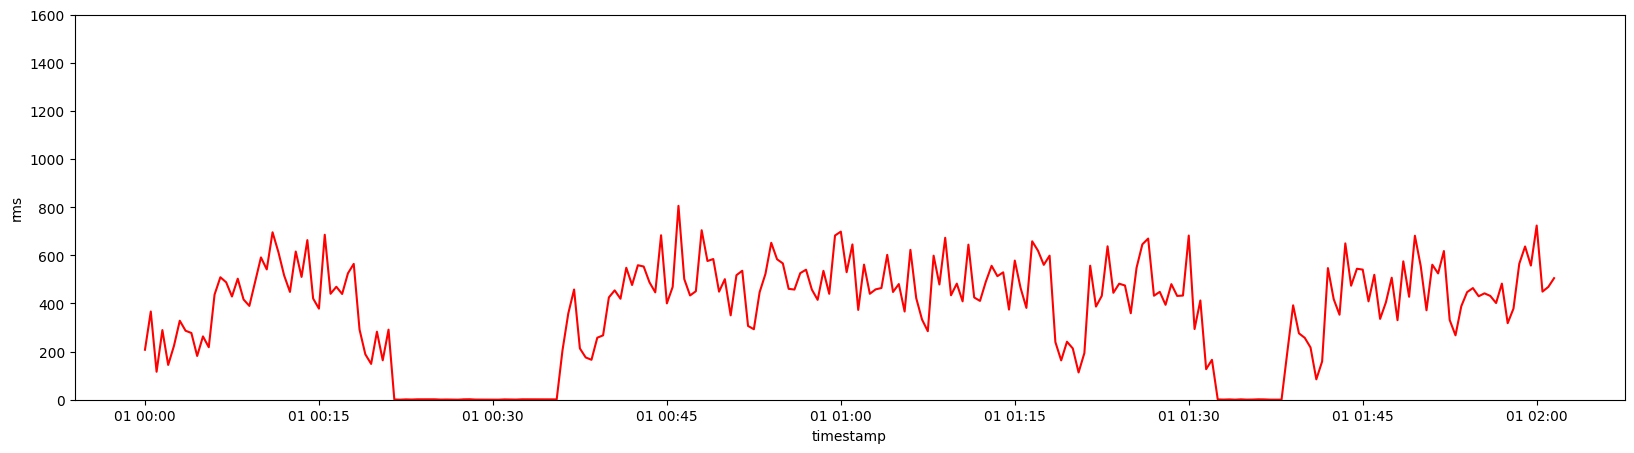

In [8]:
ax, fig = plt.subplots(figsize=(20, 5))
sns.lineplot(x='timestamp', y='rms', data=df, ax=fig, color='red')
# sns.lineplot(x='timestamp', y='rms_smoothed', data=df, ax=fig, color='blue', linestyle='--')
plt.ylim([0, 1600])
plt.show()

### Saving Data

In [10]:
# Reinstantiate without the Random Seed
generator = DataGenerator(
    state_generator,
    rms_generator,
    interval_generator,
    # kalman_filter=kf
)

In [12]:
break
for i in range(0, 11):
    df = generator.generate_time_series_data(start_date, end_date, freq)
    df.drop(['state_change'], axis=1, inplace=True)
    df.to_csv(f'data/time-series{i}.csv', index=False)

          rms        state           timestamp  state_change
0  204.019477  States.IDLE 2021-01-01 00:00:00          True
1  110.575732  States.IDLE 2021-01-01 00:00:10         False
2  281.929994  States.IDLE 2021-01-01 00:00:20         False
3  247.890607  States.IDLE 2021-01-01 00:00:30         False
4  359.185049  States.IDLE 2021-01-01 00:00:40         False
        rms       state           timestamp  state_change
0  0.236160  States.OFF 2021-01-01 00:00:00          True
1  1.485381  States.OFF 2021-01-01 00:00:10         False
2  1.128444  States.OFF 2021-01-01 00:00:20         False
3  1.190676  States.OFF 2021-01-01 00:00:30         False
4  1.441717  States.OFF 2021-01-01 00:00:40         False
        rms       state           timestamp  state_change
0  0.631770  States.OFF 2021-01-01 00:00:00          True
1  0.092417  States.OFF 2021-01-01 00:00:10         False
2  0.326326  States.OFF 2021-01-01 00:00:20         False
3  0.300611  States.OFF 2021-01-01 00:00:30         Fa

### 💡 Alternative Method: RMS Generation via TimeSynth
In this section, we introduce an alternative approach for the generation of RMS (Root Mean Square) values, employing the **TimeSynth Python library**. TimeSynth offers the ability to generate synthetic time series data which can simulate a variety of scenarios, making it a potentially useful tool for our use case.

One significant aspect of this alternative method involves the usage of **Sinusoidal waves** and **Red Noise** as key data generation mechanisms. Sinusoidal waves enable us to model periodic fluctuations, while Red Noise introduces a degree of randomness, which is often present in real-world systems.

The purpose of this examination is to compare and contrast the data generated via our original method and this TimeSynth-based alternative. This comparative study will facilitate a thorough assessment of each method's effectiveness and viability, providing a comprehensive understanding of the potential advantages and limitations.

Only the `RMSGenerator` class has changed significantly for this method. As mentioned, the random number generation based on distributions has been replaced with **Sinusoidal waves** and **Red Noise**.

In [10]:
from Codebase.utils_alternative import StateGenerator, RMSGenerator, IntervalGenerator, DataGenerator, States

In [11]:
# Defining parameters for the time series data
start_date = '2021-01-01 00:00:00'
end_date = '2021-01-01 02:00:00'
start_date = datetime.strptime(start_date, '%Y-%m-%d %H:%M:%S')
end_date = datetime.strptime(end_date, '%Y-%m-%d %H:%M:%S')
freq = '1s'
# Constants
DEFAULT_STATES = ['ACTIVE', 'IDLE', 'OFF']
DEFAULT_RMS_RANGES = {
    States.OFF: ('uniform', 0, 2),
    States.IDLE: ('normal', 250, 75),
    States.ACTIVE: ('lognormal', 6.2, 0.22)
}
DEFAULT_MIN_DURATION = 2
DEFAULT_MAX_DURATION = 250
RANDOM_SEED = 42

In [12]:
# Initialize the StateGenerator
states = [States.ACTIVE, States.IDLE, States.OFF]
# Define the transition probabilities
transition_probabilities = {
    States.OFF: {
        States.OFF: 0.5,
        States.IDLE: 0.5,
        States.ACTIVE: 0.0
    },
    States.IDLE: {
        States.OFF: 0.2,
        States.IDLE: 0.5,
        States.ACTIVE: 0.3
    },
    States.ACTIVE: {
        States.OFF: 0.0001,
        States.IDLE: 0.18,
        States.ACTIVE: 0.82
    }
}
state_generator = StateGenerator(states, transition_probabilities, random_seed=RANDOM_SEED)

In [13]:
# Initialize the IntervalGenerator
state_duration_map = {
    States.OFF: (181, 481),
    States.IDLE: (60, 211),
    States.ACTIVE: (60, 481)
}
interval_generator = IntervalGenerator(state_duration_map, random_seed=RANDOM_SEED)

In [14]:
# Initialize the RMSGenerator
rms_generator = RMSGenerator(DEFAULT_RMS_RANGES, random_seed=RANDOM_SEED)

In [15]:
kf = KalmanFilter(
    transition_matrices=[1],
    observation_matrices=[1],
    initial_state_mean=0,
    initial_state_covariance=1,
    observation_covariance=1,
    transition_covariance=10
)

In [16]:
generator = DataGenerator(
    state_generator,
    rms_generator,
    interval_generator,
    kalman_filter=kf,
    random_seed=RANDOM_SEED
)
df_2 = generator.generate_time_series_data(start_date, end_date, freq)

rms_smoothed_initial: group   
1      0    136.963456
       1    213.867392
       2    245.545694
       3    255.599436
       4    257.189762
dtype: float64
<class 'pandas.core.series.Series'>
rms_smoothed_reset: 0    136.963456
1    213.867392
2    245.545694
3    255.599436
4    257.189762
dtype: float64


### Plotting Data

In [17]:
state_counts = df['state'].value_counts()
state_counts

state
States.ACTIVE    495
States.IDLE      148
States.OFF        89
Name: count, dtype: int64

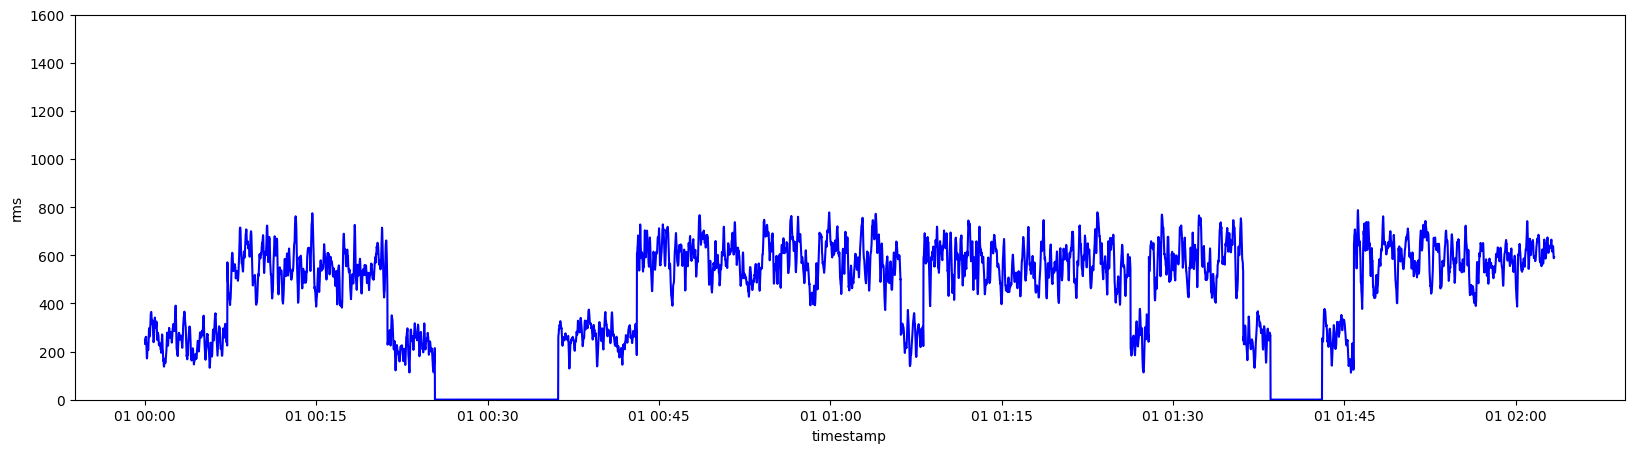

In [24]:
ax, fig = plt.subplots(figsize=(20, 5))
# sns.lineplot(x='timestamp', y='rms_smoothed', data=df_2, ax=fig, color='red')
sns.lineplot(x='timestamp', y='rms', data=df_2, ax=fig, color='blue')
plt.ylim([0, 1600])
plt.show()

## Comparing Data Generation Methods

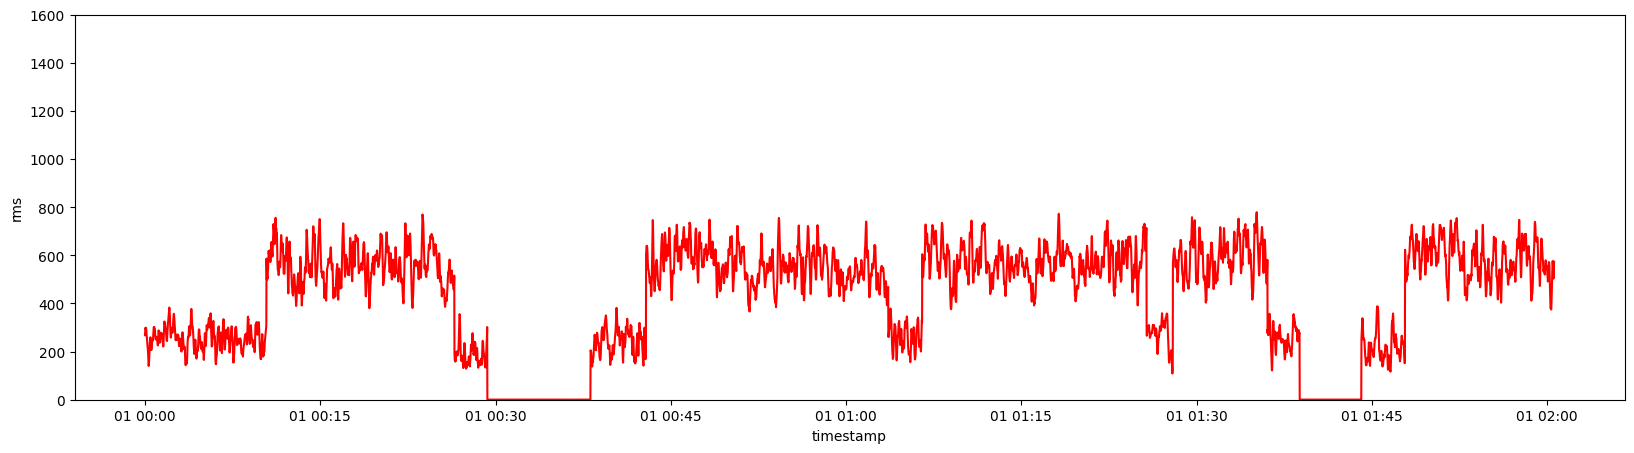

In [28]:
ax, fig = plt.subplots(figsize=(20, 5))
sns.lineplot(x='timestamp', y='rms', data=df, ax=fig, color='red')
sns.lineplot(x='timestamp', y='rms', data=df_2, ax=fig, color='blue', linestyle='--')
plt.ylim([0, 1600])
plt.show()

### Signal Generation Testing

Text(0.5, 1.0, 'Gaussian Process signal with Matern 3/2-kernel')

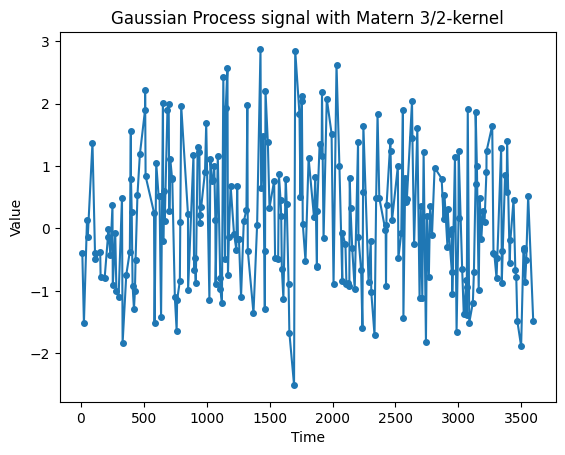

In [ ]:

gp = ts.signals.GaussianProcess(kernel='Matern', nu=3./2)
gp_series = ts.TimeSeries(signal_generator=gp)
samples = gp_series.sample(irregular_time_samples)[0]

plt.plot(irregular_time_samples, samples, marker='o', markersize=4)
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Gaussian Process signal with Matern 3/2-kernel')


In [ ]:
import numpy as np
import pandas as pd
import random

# Define constants for our states
OFF, IDLE, ACTIVE, TRANSITION = 0, 1, 2, 3
STATE_NAMES = {OFF: 'OFF', IDLE: 'IDLE', ACTIVE: 'ACTIVE', TRANSITION: 'TRANSITION'}

def generate_state_data(state, num_points):
    if state == OFF:
        return np.random.normal(loc=0.5, scale=0.1, size=num_points)
    elif state == IDLE:
        return np.random.normal(loc=2, scale=0.2, size=num_points)
    elif state == ACTIVE:
        return np.random.normal(loc=4, scale=0.3, size=num_points)
    elif state == TRANSITION:
        return np.random.normal(loc=1.5, scale=0.2, size=num_points)

def generate_timestamps(start, end, n):
    return np.linspace(start, end, num=n)

def generate_time_series_data(num_transitions, points_per_state):
    # We start in the OFF state
    current_state = OFF
    timestamps = []
    magnitudes = []
    states = []

    for i in range(num_transitions):
        # Add data for the current state
        num_points = random.randint(points_per_state[0], points_per_state[1])
        magnitudes.extend(generate_state_data(current_state, num_points))
        timestamps.extend(generate_timestamps(i, i+1, num_points))
        states.extend([STATE_NAMES[current_state]] * num_points)

        # Add data for the transition
        num_points = random.randint(points_per_state[0], points_per_state[1])
        magnitudes.extend(generate_state_data(TRANSITION, num_points))
        timestamps.extend(generate_timestamps(i+1, i+2, num_points))
        states.extend([STATE_NAMES[TRANSITION]] * num_points)

        # Move to the next state
        if current_state == OFF:
            current_state = ACTIVE
        else:
            current_state = OFF

    return pd.DataFrame({'timestamp': timestamps, 'rms': magnitudes, 'state': states})

# Call the function
df = generate_time_series_data(10, (50, 100))
print(df.head())


   timestamp       rms state
0   0.000000  0.564235   OFF
1   0.015873  0.512910   OFF
2   0.031746  0.527121   OFF
3   0.047619  0.429585   OFF
4   0.063492  0.415578   OFF


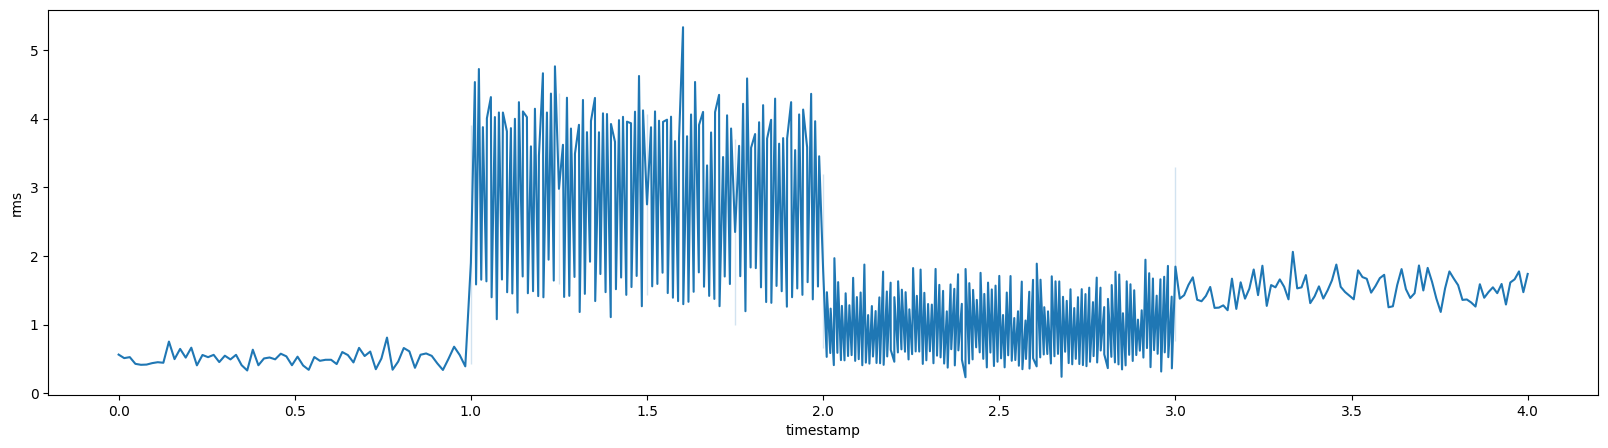

In [ ]:
ax, fig = plt.subplots(figsize=(20, 5))
sns.lineplot(x='timestamp', y='rms', data=df[:500], ax=fig)
plt.show()

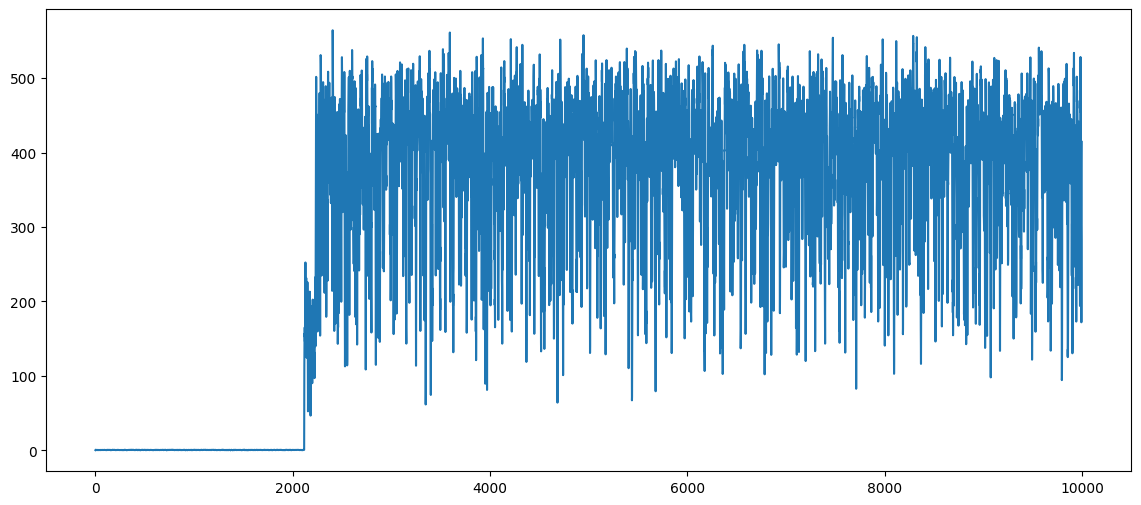

In [ ]:
import numpy as np

# Define constants for each state
STATE_OFF = "OFF"
STATE_IDLE = "IDLE"
STATE_ACTIVE = "ACTIVE"

# Define vibration ranges for each state
RANGE_OFF = (0, 1)
RANGE_IDLE = (1, 300)
RANGE_ACTIVE = (290, 600)

# Define transition probabilities
TRANSITIONS = {
    STATE_OFF: {STATE_IDLE: 1.0},  # OFF can only go to IDLE
    STATE_IDLE: {STATE_OFF: 0.05, STATE_ACTIVE: 0.95},  # IDLE can go to OFF or ACTIVE
    STATE_ACTIVE: {STATE_IDLE: 0.00005, STATE_ACTIVE: 0.99995}  # ACTIVE can go to IDLE or stay ACTIVE
}

# Define rate parameters for the exponential distribution of each state duration
DURATION_RATES = {
    STATE_OFF: 1/1000,
    STATE_IDLE: 1/100,
    STATE_ACTIVE: 1/700
}

def get_next_state(current_state):
    return np.random.choice(
        list(TRANSITIONS[current_state].keys()), 
        p=list(TRANSITIONS[current_state].values())
    )

def generate_state_data(state, num_steps):
    min_val, max_val = {
        STATE_OFF: RANGE_OFF,
        STATE_IDLE: RANGE_IDLE,
        STATE_ACTIVE: RANGE_ACTIVE
    }[state]

    return np.random.uniform(min_val, max_val, num_steps)

def generate_idle_noise(num_steps):
    return np.random.normal(0, 0.1, num_steps)

def smooth_data(data, window_size=5):
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def generate_time_series(num_steps, window_size=5):
    data = []
    states = []
    current_state = STATE_OFF
    while len(data) < num_steps:
        current_duration = np.random.exponential(1/DURATION_RATES[current_state])
        current_duration = max(1, int(current_duration))  # Ensure duration is at least 1
        current_data = generate_state_data(current_state, current_duration)

        if current_state == STATE_ACTIVE:
            idle_periods = current_duration // 10  # Introduce brief idle periods every 10 steps
            for _ in range(idle_periods):
                idle_start = np.random.randint(0, current_duration-5)  # Make sure the idle period starts well before the end
                idle_duration = np.random.randint(1, min(5, current_duration - idle_start))  # Make sure the idle period ends before the total duration
                idle_end = idle_start + idle_duration
                current_data[idle_start:idle_end] = generate_state_data(STATE_IDLE, idle_duration)

        # Apply smoothing to current data
        current_data = smooth_data(current_data, window_size)
        current_duration = len(current_data)  # Update duration based on smoothed data
        
        data.extend(current_data)
        states.extend([current_state] * current_duration)

        current_state = get_next_state(current_state)
    
    return np.array(data[:num_steps]), np.array(states[:num_steps])

# Generate synthetic time-series data
data, states = generate_time_series(10000)

# For visualization purposes:
import matplotlib.pyplot as plt
plt.figure(figsize=(14,6))
plt.plot(data)
plt.show()
